#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [5]:
%%time
canary_p = '../../../data/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.76 s, sys: 7.91 s, total: 13.7 s
Wall time: 30.3 s


In [6]:
pmpm.MEDICAID_LOB.unique()

array(['Medicare', 'Commercial', 'Other', 'ASO', 'Medicaid-HARP',
       'Medicaid-TANF', 'Medicaid-SSI', 'Medicaid-CHP', 'Medicaid-Other'],
      dtype=object)

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [7]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [8]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [9]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 12 s, sys: 7.47 s, total: 19.5 s
Wall time: 19.5 s


In [10]:
from utils import ip_er2

In [11]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ACUTE'] =  ((pmpm.IP_BIN>0) | (pmpm.ER_BIN > 0 )).astype(int)

CPU times: user 7.22 s, sys: 2.77 s, total: 9.98 s
Wall time: 9.98 s


In [12]:
%%time
pmpm[['IP_C', 'ER_C', 'ACUTE_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN', 'ACUTE']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN6', 'ER_BIN6', 'ACUTE6']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C', 'ACUTE_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)
pmpm[['IP_BIN2', 'ER_BIN2','ACUTE2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C','ACUTE_C']].diff(2).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)

CPU times: user 3min 39s, sys: 9.15 s, total: 3min 48s
Wall time: 3min 44s


#undersample
test = test.sample(random_state = 0, frac = 0.01).reset_index(drop = True)
test = test.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

%%time

test[['IP_C', 'ER_C']] = test.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
test[['IP_BIN2', 'ER_BIN2']] = test.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(test[['IP_C', 'ER_C']]).reset_index(drop = True)

In [13]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2      -3  201910        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3      -3  201911 

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [14]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 9.92 s, sys: 6.03 s, total: 16 s
Wall time: 15.9 s


### filter by principal reason

In [15]:
controls.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [16]:
%%time
treated2 = in_canary(treated.copy(), canary2)
#treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 5.18 s, sys: 66.9 ms, total: 5.25 s
Wall time: 5.24 s


In [17]:
treated2.PERS_ID.unique().shape

In [18]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 'LOB',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN2', 'ER_BIN2', 'ACUTE', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']

In [19]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
hier_cols = ['CC_DX_CNT']
hier_range = [1]
exact_match_dict = {'ACUTE':None, 'ACUTE6':None, 'ACUTE2':None, 'LOB':None}
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict, 'restrict_time':False}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" = 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)
"""


Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:315659 before they were:342223
ACUTE None
ACUTE6 None
ACUTE2 None
LOB None
There were no matches for 0 out of 1591 patients
CPU times: user 1h 12min 3s, sys: 52min 19s, total: 2h 4min 23s
Wall time: 1h 24min 12s


'\n#columns_to_match = columns_to_match + [\'IP_BIN2\', \'ER_BIN2\']\npropensity_func_args = {\'match_on\':columns_to_match, \'neighbors_per_treated\': 5, \'onset\': "CC_DIABETES", "onset_val" = 1}\nmatched0, matched_data0 = matched_population(treated2.copy(), \n                                           controls.copy(),\n                                           propensity_func, \n                                           propensity_func_args)\n'

####  In addition to the previously created matched groups create a random group

In [20]:
Path('./tempHybridSelectionMoreData').mkdir(exist_ok = True)
p = './tempHybridSelectionMoreData/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [21]:
random_matching_func_args = {'neighbors_per_treated': 5}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [22]:
random_controls.to_pickle(p+'random.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [23]:
from utils import statistics_first_month

In [24]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [25]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 2min 21s, sys: 6.9 s, total: 2min 28s
Wall time: 2min 28s


In [26]:
import scipy.stats as sts

In [27]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [28]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

## Statistics on matching date

In [29]:
alli

Treated Matched Controls    T-Test           Genaral Population      Random
                       mean             mean    t-stat      pval               mean        mean
AGE_AT_MIDMONTH   50.202388        51.824269 -4.415781  0.000010          44.643167   47.578065
ALLOW_AMT        676.302326       875.627715 -1.861640  0.062695        1086.869268  680.204761
MBR_GNDR           0.205531         0.200503  0.440857  0.659330           0.440779    0.429230
CC_TOBACCO         0.062225         0.068390 -0.867222  0.385849           0.076138    0.096365
CC_PRESSURE        0.001257         0.002334 -0.828251  0.407556           0.007643    0.006527
CC_OBESITY         0.456945         0.429007  1.982642  0.047446           0.113117    0.228052
LOB                0.952231         0.948663  0.573001  0.566662           0.759449    0.784873
CC_HYPERTENSION    0.324324         0.317717  0.498584  0.618088           0.216240    0.261326
CC_HYPOTHYROID     0.094280         0.089391  0.599464  0.548882           0.048990    0.066675
CC_DX_CNT          2.703331         2.839167 -2.056910  0.039731           1.882424    2.388021
IP_BIN2            0.010057         0.012386 -0.700377  0.483715           0.020831    0.014589
ER_BIN2            0.029541         0.034105 -0.847248  0.396885           0.046643    0.042616
ACUTE              0.014456         0.023335 -2.160632  0.030757           0.062807    0.026875
ACUTE2             0.037712         0.045234 -1.206670  0.227599           0.062807    0.053878
ACUTE6             0.110622         0.126189 -1.283814  0.199248           0.062807    0.160481
IP_BIN6            0.027027         0.034644 -1.211652  0.225686           0.020831    0.044791
ER_BIN6            0.087995         0.097290 -0.889750  0.373630           0.046643    0.124904

In [30]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [31]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [32]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated              Matched Controls                     T-Test Genaral Population      Random
                       mean          std             mean          std          pval               mean        mean
AGE_AT_MIDMONTH   50.609018    12.498347        51.822376    12.614026  3.012724e-36          50.562788   49.841932
ALLOW_AMT        774.488888  3977.523078       810.005903  3856.097614  2.327041e-01         863.412296  728.863981
MBR_GNDR           0.186437     0.389468         0.179054     0.383400  1.229253e-02           0.432518    0.421937
CC_TOBACCO         0.064386     0.245445         0.072909     0.259989  1.493111e-05           0.101788    0.105292
CC_PRESSURE        0.002195     0.046800         0.002484     0.049774  4.433502e-01           0.013009    0.008076
CC_OBESITY         0.506722     0.499966         0.475021     0.499379  1.233793e-16           0.256968    0.278993
LOB                0.953677     0.210189         0.947363     0.223309  1.865455e-04           0.804859    0.803918
CC_HYPERTENSION    0.322480     0.467436         0.335665     0.472226  2.609267e-04           0.334809    0.301956
CC_HYPOTHYROID     0.094430     0.292433         0.092960     0.290378  5.095109e-01           0.079339    0.074908
CC_DX_CNT          2.878270     2.239593         3.049854     2.303141  1.400667e-22           2.987871    2.729799
IP_BIN2            0.007682     0.087836         0.011378     0.112369  7.172033e-06           0.020410    0.015654
ER_BIN2            0.025334     0.170001         0.030558     0.181888  1.441545e-04           0.044070    0.035658
ACUTE              0.015228     0.122460         0.019375     0.137839  5.806332e-05           0.030907    0.023512
ACUTE2             0.031827     0.188605         0.039920     0.209256  2.548457e-07           0.060833    0.048333
ACUTE6             0.101061     0.401935         0.121736     0.423002  1.142327e-10           0.168764    0.149691
IP_BIN6            0.024694     0.165185         0.034381     0.218011  1.117675e-09           0.055618    0.046796
ER_BIN6            0.080209     0.367004         0.093623     0.364724  1.648257e-06           0.123113    0.111790

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [33]:
#mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 
                                     #'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits', 'Line of Bussiness']))
mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [34]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [35]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [36]:
from diabetes_onset_plotter import plot_hist


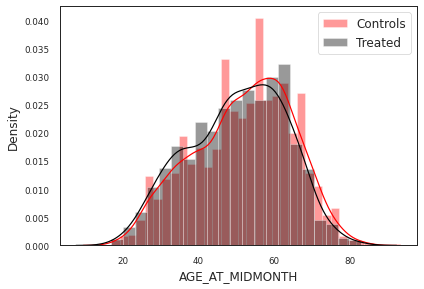

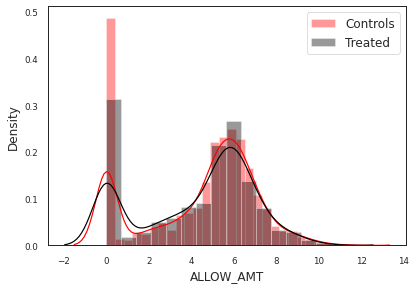

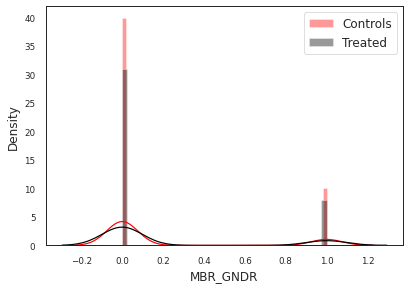

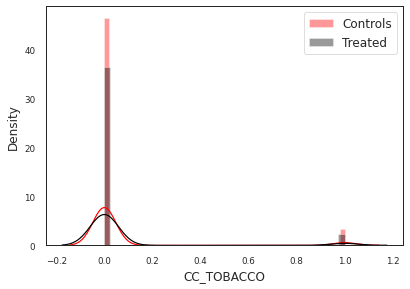

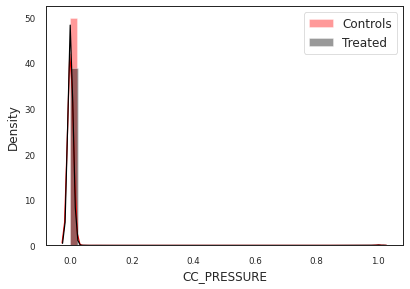

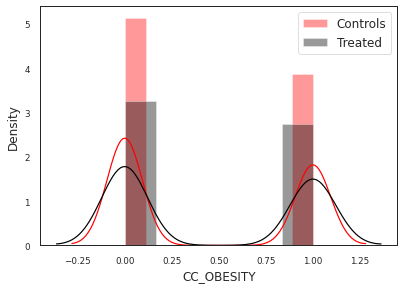

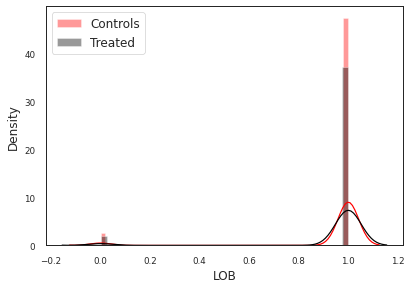

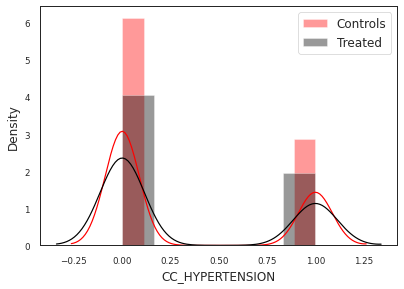

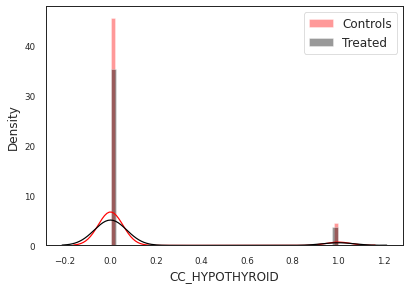

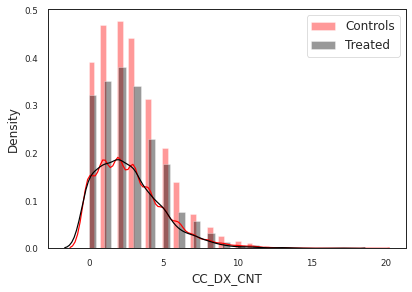

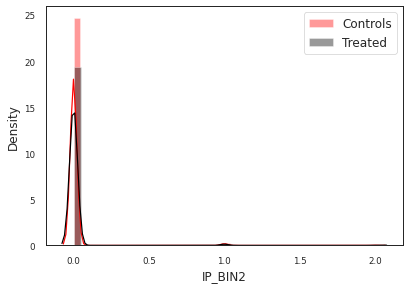

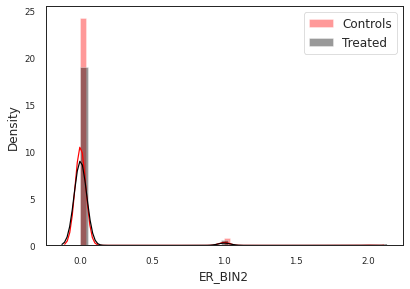

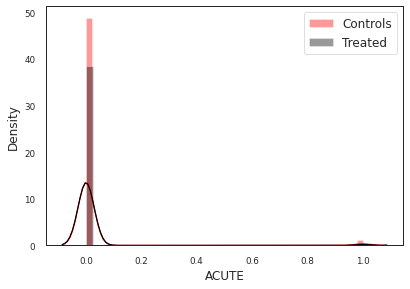

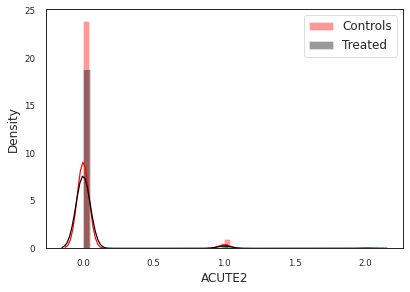

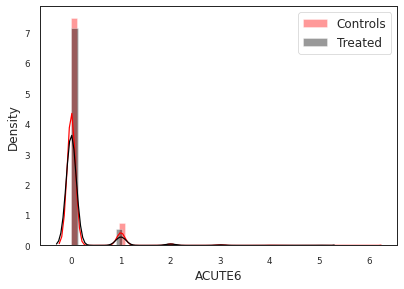

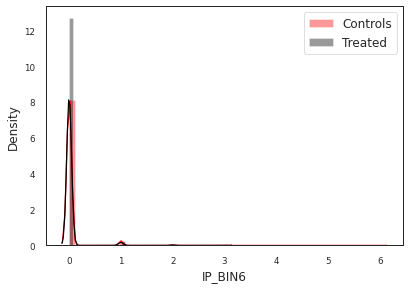

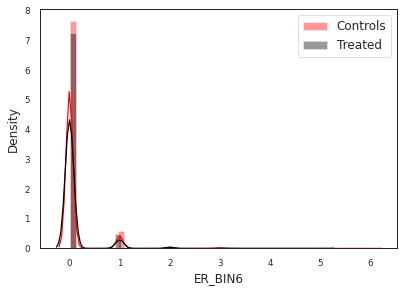

In [37]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [38]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

In [39]:
all_paper


Treated  Matched Controls  T-Statistic  p-value  General Population  Random Match  Difference
AGE_AT_MIDMONTH   50.202            51.824       -4.416    0.000              44.643        47.578      -1.622
ALLOW_AMT        676.302           875.628       -1.862    0.063            1086.869       680.205    -199.326
MBR_GNDR           0.206             0.201        0.441    0.659               0.441         0.429       0.005
CC_TOBACCO         0.062             0.068       -0.867    0.386               0.076         0.096      -0.006
CC_PRESSURE        0.001             0.002       -0.828    0.408               0.008         0.007      -0.001
CC_OBESITY         0.457             0.429        1.983    0.047               0.113         0.228       0.028
LOB                0.952             0.949        0.573    0.567               0.759         0.785       0.003
CC_HYPERTENSION    0.324             0.318        0.499    0.618               0.216         0.261       0.006
CC_HYPOTHYROID     0.094             0.089        0.599    0.549               0.049         0.067       0.005
CC_DX_CNT          2.703             2.839       -2.057    0.040               1.882         2.388      -0.136
IP_BIN2            0.010             0.012       -0.700    0.484               0.021         0.015      -0.002
ER_BIN2            0.030             0.034       -0.847    0.397               0.047         0.043      -0.004
ACUTE              0.014             0.023       -2.161    0.031               0.063         0.027      -0.009
ACUTE2             0.038             0.045       -1.207    0.228               0.063         0.054      -0.007
ACUTE6             0.111             0.126       -1.284    0.199               0.063         0.160      -0.015
IP_BIN6            0.027             0.035       -1.212    0.226               0.021         0.045      -0.008
ER_BIN6            0.088             0.097       -0.890    0.374               0.047         0.125      -0.009

In [40]:
only_means

Treated  Matched Controls  General Population  Random Match
AGE_AT_MIDMONTH   50.202            51.824              44.643        47.578
ALLOW_AMT        676.302           875.628            1086.869       680.205
MBR_GNDR           0.206             0.201               0.441         0.429
CC_TOBACCO         0.062             0.068               0.076         0.096
CC_PRESSURE        0.001             0.002               0.008         0.007
CC_OBESITY         0.457             0.429               0.113         0.228
LOB                0.952             0.949               0.759         0.785
CC_HYPERTENSION    0.324             0.318               0.216         0.261
CC_HYPOTHYROID     0.094             0.089               0.049         0.067
CC_DX_CNT          2.703             2.839               1.882         2.388
IP_BIN2            0.010             0.012               0.021         0.015
ER_BIN2            0.030             0.034               0.047         0.043
ACUTE              0.014             0.023               0.063         0.027
ACUTE2             0.038             0.045               0.063         0.054
ACUTE6             0.111             0.126               0.063         0.160
IP_BIN6            0.027             0.035               0.021         0.045
ER_BIN6            0.088             0.097               0.047         0.125

In [41]:
only_stats

Difference  T-Statistic  p-value
AGE_AT_MIDMONTH      -1.622       -4.416    0.000
ALLOW_AMT          -199.326       -1.862    0.063
MBR_GNDR              0.005        0.441    0.659
CC_TOBACCO           -0.006       -0.867    0.386
CC_PRESSURE          -0.001       -0.828    0.408
CC_OBESITY            0.028        1.983    0.047
LOB                   0.003        0.573    0.567
CC_HYPERTENSION       0.006        0.499    0.618
CC_HYPOTHYROID        0.005        0.599    0.549
CC_DX_CNT            -0.136       -2.057    0.040
IP_BIN2              -0.002       -0.700    0.484
ER_BIN2              -0.004       -0.847    0.397
ACUTE                -0.009       -2.161    0.031
ACUTE2               -0.007       -1.207    0.228
ACUTE6               -0.015       -1.284    0.199
IP_BIN6              -0.008       -1.212    0.226
ER_BIN6              -0.009       -0.890    0.374

In [42]:
pmpm.MYR.max()

202104